# Video Analysis

In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import numpy as np
from glob import glob

# set decimal precision
pd.set_option('precision', 3)

# set plot parameters
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
plt.rcParams.update(
    {
        'axes.grid': True,
        'axes.spines.bottom': False,
        'axes.spines.left': False,
        'axes.spines.right': False,
        'axes.spines.top': False,
        'font.family': 'Iosevka sbruder'
    }
)

In [2]:
project = 'chaospendel/coole_bewegung_0'

In [3]:
tracking_data = pd.read_csv(f'data/{project}.csv')
# remove all unneeded columns and rename them for easier handling
tracking_data = tracking_data[['time (s)', 'x (m)', 'y (m)', 'rotation']]
tracking_data = tracking_data.rename(columns={'time (s)': 't', 'x (m)': 'x', 'y (m)': 'y'})

In [4]:
# add new columns for distance, velocity and acceleration
tracking_data['s'] = 0.0 * len(tracking_data)
tracking_data['v'] = 0.0 * len(tracking_data)
tracking_data['a'] = 0.0 * len(tracking_data)

# calculate velocities and insert them
for idx in tracking_data.index[1:]:
    xdelta = tracking_data.loc[idx]['x'] - tracking_data.loc[idx - 1]['x']
    ydelta = tracking_data.loc[idx]['y'] - tracking_data.loc[idx - 1]['y']
    tdelta = tracking_data.loc[idx]['t'] - tracking_data.loc[idx - 1]['t']
    distance = math.sqrt(xdelta**2 + ydelta**2)
    velocity = distance / tdelta
    tracking_data.at[idx, 's'] = distance + tracking_data.loc[idx - 1]['s']
    tracking_data.at[idx, 'v'] = velocity
    
    vdelta = tracking_data.loc[idx]['v'] - tracking_data.loc[idx - 1]['v']
    acceleration = vdelta / tdelta
    tracking_data.at[idx, 'a'] = acceleration
    
    tracking_data.at[idx, 'rotation'] = tracking_data.loc[idx]['rotation'] - 180

In [5]:
# remove first two rows (too high acceleration)
tracking_data = tracking_data.drop([0, 1])

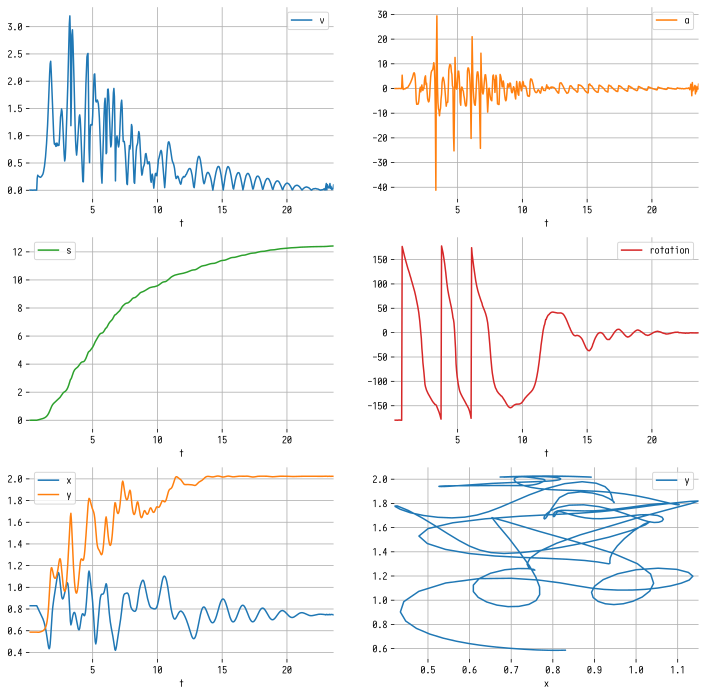

In [6]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
tracking_data.plot(x='t', y=['v', 'a', 's', 'rotation'], subplots=True, ax=[*ax[0], *ax[1]])
tracking_data.plot(x='t', y=['x', 'y'], ax=ax[2][0])
tracking_data.plot(x='x', y='y', ax=ax[2][1])
plt.savefig(f'data/{project}.svg', bbox_inches='tight')

In [7]:
project_ = '_'.join(project.split('_')[:-1])

In [8]:
tracking_data = sorted(glob(f'data/{project_}*.csv'))
tracking_data = [pd.read_csv(file) for file in tracking_data]
tracking_data = [df[['x (m)', 'y (m)']] for df in tracking_data]
tracking_data = [df.rename(columns={'x (m)': f'x ({idx})', 'y (m)': f'y ({idx})'}) for idx, df in enumerate(tracking_data)]
tracking_data = pd.concat(tracking_data, axis=1)

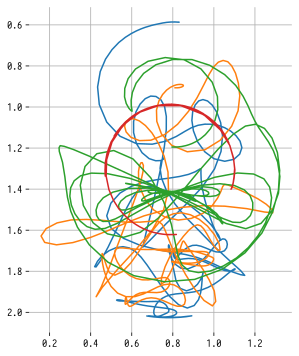

In [9]:
xs = list(zip(*tracking_data.T[[col.startswith('x') for col in tracking_data.columns]].T.values))
ys = list(zip(*tracking_data.T[[col.startswith('y') for col in tracking_data.columns]].T.values))
plt.figure(figsize=(6, 6))
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis()
for idx in range(len(xs)):
    plt.plot(xs[idx], ys[idx])
plt.savefig(f'data/{project_}_movement.svg', bbox_inches='tight')